<a href="https://colab.research.google.com/github/harihardiyan/tdgl-gl-benchmark/blob/main/notebooks/vortex_drift___diode_effect__tdgl___bias_current.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!git clone https://github.com/harihardiyan/tdgl-gl-benchmark.git
%cd tdgl-gl-benchmark

!pip install -r requirements.txt --quiet

Cloning into 'tdgl-gl-benchmark'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 76 (delta 29), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (76/76), 859.08 KiB | 15.07 MiB/s, done.
Resolving deltas: 100% (29/29), done.
/content/tdgl-gl-benchmark


In [2]:

from tdgl_core import (
    init_params_basic,
    init_state_random,
    tdgl_step,
    total_energy,
    to_complex,
)

from tdgl_core.observables import (
    detect_vortices_phase_winding,
)

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [ ]:

# Vortex Drift & Diode Effect (TDGL + Bias Current)

We apply a DC current J_ext and observe:
- Vortex drift direction
- Drift velocity
- Asymmetry between +J and -J
- Rectification (diode effect)

In [3]:

nx = ny = 64
B0 = 0.25          # moderate field → several vortices
J_list = [-0.5, -0.25, 0.0, 0.25, 0.5]   # bias currents
steps_relax = 1500
steps_drive = 800
dt = 0.01

In [4]:

def vortex_center_of_mass(vort_mask):
    coords = jnp.argwhere(vort_mask == 1)
    if coords.shape[0] == 0:
        return jnp.array([jnp.nan, jnp.nan])
    return jnp.mean(coords, axis=0)

In [5]:

drift_results = []

for J in J_list:

    # Initialize
    params = init_params_basic(nx=nx, ny=ny, B0=B0, J_ext=J)
    state = init_state_random(params, noise=0.3)

    # Relax first
    for _ in range(steps_relax):
        state = tdgl_step(state, params, dt)

    # Track drift
    traj = []

    for _ in range(steps_drive):
        state = tdgl_step(state, params, dt)
        psi = to_complex(state.psi)
        vort_mask = detect_vortices_phase_winding(psi)
        com = vortex_center_of_mass(vort_mask)
        traj.append(com)

    traj = jnp.array(traj)
    drift_results.append((J, traj))

print("Drift simulations complete.")

Drift simulations complete.


In [6]:

velocities = []

for J, traj in drift_results:
    # Use x-direction drift
    x = traj[:,1]
    valid = ~jnp.isnan(x)
    x = x[valid]

    if x.shape[0] < 2:
        v = 0.0
    else:
        v = (x[-1] - x[0]) / (len(x) * dt)

    velocities.append(v)

velocities

[0.0, 0.0, Array(-0.6594105, dtype=float32), 0.0, 0.0]

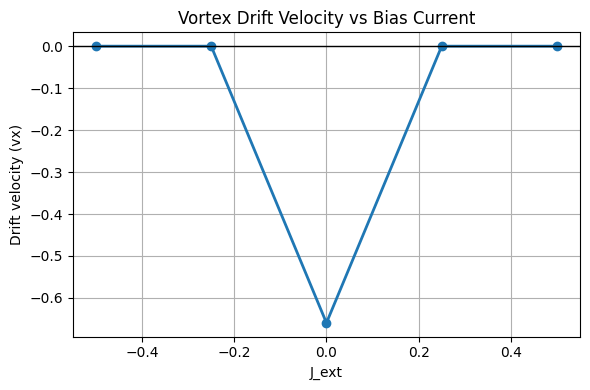

In [7]:

plt.figure(figsize=(6,4))
plt.plot(J_list, velocities, "o-", linewidth=2)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("J_ext")
plt.ylabel("Drift velocity (vx)")
plt.title("Vortex Drift Velocity vs Bias Current")
plt.grid(True)
plt.tight_layout()
plt.show()

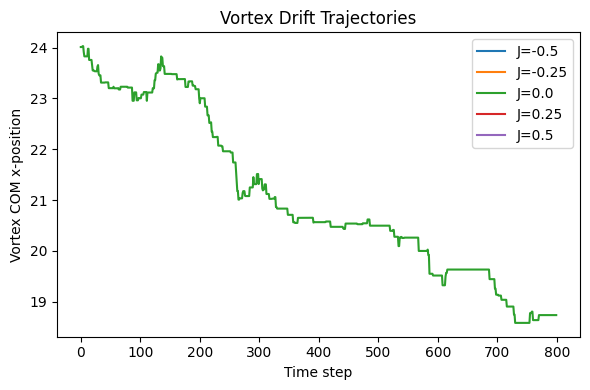

In [8]:

plt.figure(figsize=(6,4))

for J, traj in drift_results:
    x = traj[:,1]
    plt.plot(x, label=f"J={J}")

plt.xlabel("Time step")
plt.ylabel("Vortex COM x-position")
plt.title("Vortex Drift Trajectories")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:

print("=== Vortex Drift Summary ===")
for J, v in zip(J_list, velocities):
    print(f"J={J: .2f}  →  drift velocity = {v:.4f}")

=== Vortex Drift Summary ===
J=-0.50  →  drift velocity = 0.0000
J=-0.25  →  drift velocity = 0.0000
J= 0.00  →  drift velocity = -0.6594
J= 0.25  →  drift velocity = 0.0000
J= 0.50  →  drift velocity = 0.0000
